# 0. Three particle types classification

In this notebook, we attempt to classify three particle types: electron, muon and proton.

We use a slimmed down dataset of a public dataset from the [Deep Learn Physics Challenge](http://deeplearnphysics.org/DataChallenge/). The dataset is a set of images of three types particles (electron, muon and proton) projected in the xy-plane.


In [1]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
from os.path import join

# need some certainty in data processing
np.random.seed(1234)
tf.random.set_seed(1234)

Using TensorFlow v2.7.0


## Google Cloud Storage Boilerplate

The following two cells have some boilerplate to mount the Google Cloud Storage bucket containing the data used for this notebook to your Google Colab file system. **Even you are not using Google Colab, please make sure you run these two cells.** 

To access the data from Google Colab, you need to:

1. Run the first cell;
2. Follow the link when prompted (you may be asked to log in with your Google account);
3. Copy the Google SDK token back into the prompt and press `Enter`;
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [2]:
# variables passed to bash; do not change
project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'
colab_data_path = '/content/sciml-workshop-data/'

try:
    from google.colab import auth
    auth.authenticate_user()
    google_colab_env = 'true'
    data_path = colab_data_path
except:
    google_colab_env = 'false'
    ###################################################
    ######## specify your local data path here ########
    ###################################################
    with open('../local_data_path.txt', 'r') as f: data_path = f.read().splitlines()[0]

In [3]:
%%bash -s {google_colab_env} {colab_data_path} {project_id} {bucket_name}

# running locally
if ! $1; then
    echo "Running notebook locally."
    exit
fi

# already mounted
if [ -d $2 ]; then
    echo "Data already mounted."
    exit
fi

# mount the bucket
echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
apt -qq update
apt -qq install gcsfuse
gcloud config set project $3
mkdir $2
gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 $4 $2

Running notebook locally.


---

# 1. Load the dataset

### Read raw data

Our data are stored in the hdf files physics/phy_cls3_train.h5 and physics/phy_cls3_train.h5 containing 15,000 and 3,000 images, respectively. Images are three types particles (electron, muon and proton) projected in the xy-plane. 'phy_cls3_train.h5' includes 5,000 images per particle type and 'phy_cls3_train.h5' includes 1,000 images per particle type. 

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# load dataset
with h5py.File(join(data_path, 'Physics/phy_cls3_train.h5'), 'r') as F:

    # downsample images to fit in memory
    x_train = np.array(F['images'][:, ::2, ::2])
    x_train = np.expand_dims(x_train, axis = -1)
    x_train = x_train.astype(np.float32)
    x_train = x_train/255.
    y_train = np.array(F['labels'])
    y_train = y_train.astype(np.float32)
    

with h5py.File(join(data_path, 'Physics/phy_cls3_test.h5'), 'r') as F:

    # downsample images to fit in memory
    x_test = np.array(F['images'][:, ::2, ::2])
    x_test = np.expand_dims(x_test, axis = -1)
    x_test = x_test.astype(np.float32)
    x_test =x_test/255.   
    y_test = np.array(F['labels'])
    y_test = y_test.astype(np.float32)
    

# string labels
string_labels = ['electron', 'muon', 'proton']

# print info
print("Number of training data: %d" % len(y_train))
print("Number of test data: %d" % len(y_test))
print("Image pixels: %s" % str(x_train[0, :, :, 0].shape))
print("Number of channels: %s" % str(x_train.shape[-1]))
print("Number of labels: %s" % len(string_labels))
```
    
</p>
</details>

In [4]:
# load dataset
with h5py.File(join(data_path, 'Physics/phy_cls3_train.h5'), 'r') as F:

    # downsample images to fit in memory
    x_train = np.array(F['images'][:, ::2, ::2])
    x_train = np.expand_dims(x_train, axis = -1)
    x_train = x_train.astype(np.float32)
    x_train = x_train/255.
    y_train = np.array(F['labels'])
    y_train = y_train.astype(np.float32)
    

with h5py.File(join(data_path, 'Physics/phy_cls3_test.h5'), 'r') as F:

    # downsample images to fit in memory
    x_test = np.array(F['images'][:, ::2, ::2])
    x_test = np.expand_dims(x_test, axis = -1)
    x_test = x_test.astype(np.float32)
    x_test =x_test/255.   
    y_test = np.array(F['labels'])
    y_test = y_test.astype(np.float32)
    

# string labels
string_labels = ['electron', 'muon', 'proton']

# print info
print("Number of training data: %d" % len(y_train))
print("Number of test data: %d" % len(y_test))
print("Image pixels: %s" % str(x_train[0, :, :, 0].shape))
print("Number of channels: %s" % str(x_train.shape[-1]))
print("Number of labels: %s" % len(string_labels))

Number of training data: 15000
Number of test data: 3000
Image pixels: (128, 128, 1)
Number of channels: 1
Number of labels: 3


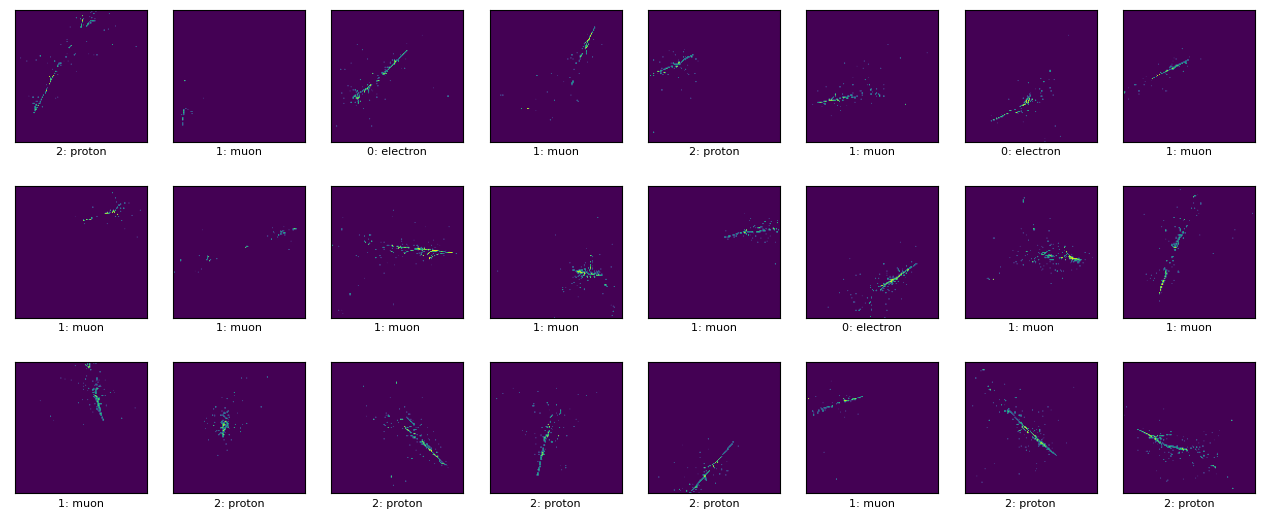

In [5]:
# function to plot an image in a subplot
def subplot_image(image, label, nrows=1, ncols=1, iplot=0, label2='', label2_color='r'):
    plt.subplot(nrows, ncols, iplot + 1)
    plt.imshow(image.squeeze())
    plt.xlabel(label, c='k', fontsize=8)
    plt.title(label2, c=label2_color, fontsize=8, y=-0.33)
    plt.xticks([])
    plt.yticks([])
    
# ramdomly plot some images and their labels
nrows = 3
ncols = 8
plt.figure(dpi=100, figsize=(ncols * 2, nrows * 2.2))
for iplot, idata in enumerate(np.random.choice(len(y_train), nrows * ncols)):
    label = "%d: %s" % (y_train[idata], string_labels[int(y_train[idata])])
    subplot_image(x_train[idata], label, nrows, ncols, iplot)
plt.show()

---

# 2. Build the network

The inputs are 2D images. Therefore, we build a network with 2D convolutional layers.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# build the network architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), strides = 1, input_shape=(128, 128, 1)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(64, (3, 3), strides = 1))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(128, (3, 3), strides = 1))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(256, (3, 3), strides = 1))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPool2D((2, 2)))

model.add(Flatten())
model.add(Dense(3, activation='softmax'))

# print summary
model.summary()
```
    
</p>
</details>

In [6]:
# build the network architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), strides = 1, input_shape=(128, 128, 1)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(64, (3, 3), strides = 1))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(128, (3, 3), strides = 1))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(256, (3, 3), strides = 1))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPool2D((2, 2)))

model.add(Flatten())
model.add(Dense(3, activation='softmax'))

# print summary
model.summary()

2022-03-28 13:55:32.053759: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-28 13:55:32.604476: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14773 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3b:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

### Compile and train the model

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# optimizer, loss, metrics
opt = tf.keras.optimizers.RMSprop()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# train the model

history = model.fit(x_train, y_train, epochs=50, batch_size=64,
                             validation_data=(x_test, y_test))
```
    
</p>
</details>

In [7]:
# optimizer, loss, metrics
opt = tf.keras.optimizers.RMSprop()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# train the model

history = model.fit(x_train, y_train, epochs=50, batch_size=64,
                             validation_data=(x_test, y_test))

2022-03-28 13:55:32.907597: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 983040000 exceeds 10% of free system memory.
2022-03-28 13:55:33.696327: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 983040000 exceeds 10% of free system memory.


Epoch 1/50


2022-03-28 13:55:35.435574: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-03-28 13:55:35.977769: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-28 13:55:35.978353: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-28 13:55:35.978366: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-03-28 13:55:35.978910: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-28 13:55:35.978965: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


235/235 [==============================] - 11s 35ms/step - loss: 1.8108 - accuracy: 0.3452 - val_loss: 1.6261 - val_accuracy: 0.3333
Epoch 2/50
235/235 [==============================] - 8s 32ms/step - loss: 1.2145 - accuracy: 0.3399 - val_loss: 1.1116 - val_accuracy: 0.3407
Epoch 3/50
235/235 [==============================] - 7s 32ms/step - loss: 1.1317 - accuracy: 0.3529 - val_loss: 1.1970 - val_accuracy: 0.3243
Epoch 4/50
235/235 [==============================] - 7s 31ms/step - loss: 1.1068 - accuracy: 0.3840 - val_loss: 1.1859 - val_accuracy: 0.3303
Epoch 5/50
235/235 [==============================] - 7s 31ms/step - loss: 1.0797 - accuracy: 0.4199 - val_loss: 1.6689 - val_accuracy: 0.3357
Epoch 6/50
235/235 [==============================] - 7s 31ms/step - loss: 1.0421 - accuracy: 0.4661 - val_loss: 1.2564 - val_accuracy: 0.3333
Epoch 7/50
235/235 [==============================] - 7s 32ms/step - loss: 0.9811 - accuracy: 0.5173 - val_loss: 1.3809 - val_accuracy: 0.3333
Epoch 8/5

---

# 3. Analyse results 

### Plot training history

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# plot accuracy
plt.figure(dpi=100, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history[acc_str], label='Accuracy on training data')
plt.plot(history.history['val_' + acc_str], label='Accuracy on test data')
plt.legend()
plt.title("Accuracy")

# plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss on training data')
plt.plot(history.history['val_loss'], label='Loss on test data')
plt.legend()
plt.title("Loss")
plt.show()
```
    
</p>
</details>

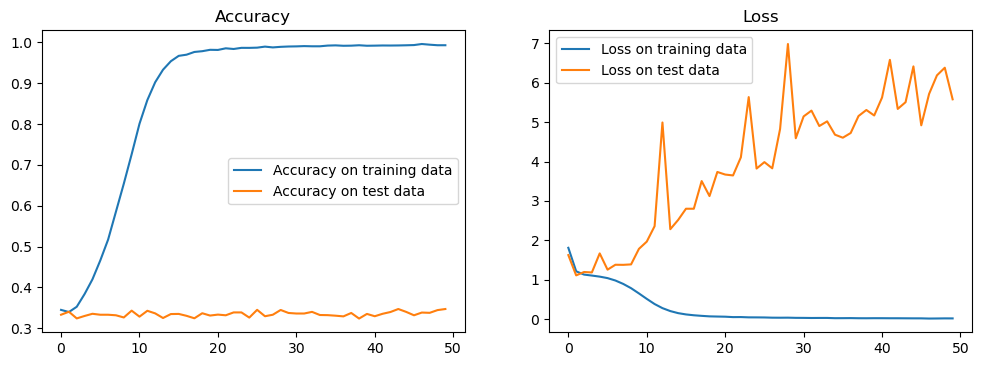

In [8]:
# plot accuracy
plt.figure(dpi=100, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history[acc_str], label='Accuracy on training data')
plt.plot(history.history['val_' + acc_str], label='Accuracy on test data')
plt.legend()
plt.title("Accuracy")

# plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss on training data')
plt.plot(history.history['val_loss'], label='Loss on test data')
plt.legend()
plt.title("Loss")
plt.show()

### Make predictions

In [9]:
# use test images to predict
pred_lables = model.predict(x_test).argmax(axis=1)

Number of test data: 3000
Number of wrong predictions: 1958


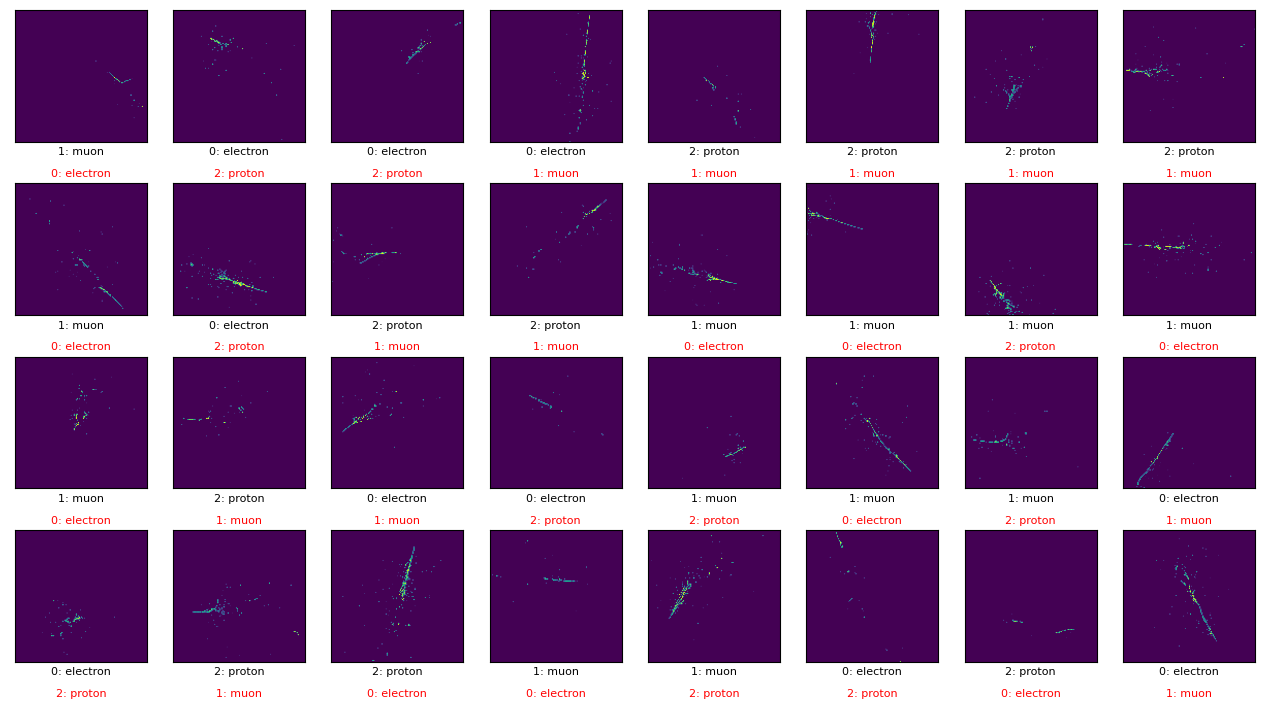

In [10]:
# get the indices of wrong predictions
id_wrong = np.where(pred_lables != y_test)[0]
print("Number of test data: %d" % y_test.size)
print("Number of wrong predictions: %d" % id_wrong.size)

# plot the wrong predictions
nrows = 4
ncols = 8
plt.figure(dpi=100, figsize=(ncols * 2, nrows * 2.2))
for iplot, idata in enumerate(np.random.choice(id_wrong, nrows * ncols)):
    label = "%d: %s" % (y_test[idata], string_labels[int(y_test[idata])])
    label2 = "%d: %s" % (pred_lables[idata], string_labels[pred_lables[idata]])
    subplot_image(x_test[idata], label, nrows, ncols, iplot, label2, 'r')
plt.show()

---

# 4. Exercises


Notice that the accuracies for the training and the test data diverge as the model trains. This is a classic symptom of [overfitting](https://en.wikipedia.org/wiki/Overfitting), that is, our model corresponds too closely to the training data so that it cannot fit the test data with an equivalent accuracy.

* Add more convolutional layers
* Regularise the network and re-train